# Exercise 7

# Capital Bikeshare data

## Introduction

- Capital Bikeshare dataset from Kaggle: [data](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)
- Each observation represents the bikeshare rentals initiated during a given hour of a given day

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [2]:
# read the data and set "datetime" as the index
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)

In [3]:
# "count" is a method, so it's best to rename that column
bikes.rename(columns={'count':'total'}, inplace=True)

In [4]:
# create "hour" as its own feature
bikes['hour'] = bikes.index.hour

In [5]:
bikes.head()

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  total  hour  
datetime                                                                   
2011-01-01 00:00:00        81        0.0       3          13     16     0  
2011-01-01 01:00:00        80        0.0       8          32     40     1  
2011-01-01 02:00:00        80        0.0       5          27     32     2  
2011-01-01 03:00:00        75        0.0       3          10     13     3  
2011-01-01 04:00:00        75        0.0       0           1      1     4

In [6]:
bikes.tail()

season  holiday  workingday  weather   temp   atemp  \
datetime                                                                   
2012-12-19 19:00:00       4        0           1        1  15.58  19.695   
2012-12-19 20:00:00       4        0           1        1  14.76  17.425   
2012-12-19 21:00:00       4        0           1        1  13.94  15.910   
2012-12-19 22:00:00       4        0           1        1  13.94  17.425   
2012-12-19 23:00:00       4        0           1        1  13.12  16.665   

                     humidity  windspeed  casual  registered  total  hour  
datetime                                                                   
2012-12-19 19:00:00        50    26.0027       7         329    336    19  
2012-12-19 20:00:00        57    15.0013      10         231    241    20  
2012-12-19 21:00:00        61    15.0013       4         164    168    21  
2012-12-19 22:00:00        61     6.0032      12         117    129    22  
2012-12-19 23:00:00        66     8.9981       4          84     88    23

- **hour** ranges from 0 (midnight) through 23 (11pm)
- **workingday** is either 0 (weekend or holiday) or 1 (non-holiday weekday)

# Exercise 7.1

Run these two `groupby` statements and figure out what they tell you about the data.

In [7]:
# mean rentals for each value of "workingday"
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [8]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

# Exercise 7.2

Run this plotting code, and make sure you understand the output. Then, separate this plot into two separate plots conditioned on "workingday". (In other words, one plot should display the hourly trend for "workingday=0", and the other should display the hourly trend for "workingday=1".)

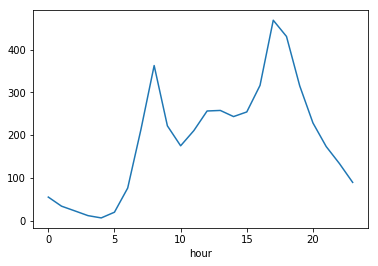

In [9]:
# mean rentals for each value of "hour"
bikes.groupby('hour').total.mean().plot()

Plot for workingday == 0 and workingday == 1

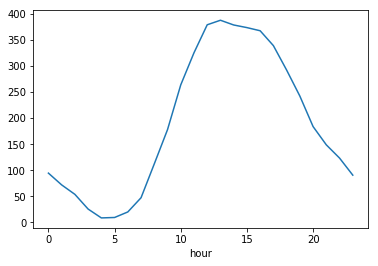

In [10]:
# hourly rental trend for "workingday=0"
bikes[bikes.workingday==0].groupby('hour').total.mean().plot()

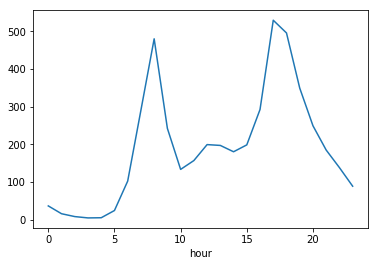

In [11]:
# hourly rental trend for "workingday=1"
bikes[bikes.workingday==1].groupby('hour').total.mean().plot()

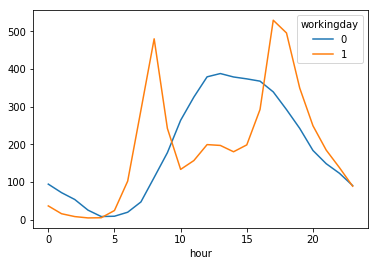

In [12]:
# combine the two plots
bikes.groupby(['hour', 'workingday']).total.mean().unstack().plot()

#### Se evidencia una marcada diferencia en el uso de la bicicleta entre los dias habiles y festivos. Mientras que en los dias habiles se presentan picos entre las 7 y las 8  y a entre las 16 y las 18, los dias festivos se presenta un uso más centrado entre las 10 y las 16. 

# Exercise 7.3

Fit a linear regression model to the entire dataset, using "total" as the response and "hour" and "workingday" as the only features. Then, print the coefficients and interpret them. What are the limitations of linear regression in this instance?

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

lm = LinearRegression().fit(y=bikes['total'],X=bikes[['workingday','hour']])
pred = lm.predict(bikes[['workingday','hour']])

print('Coef.:\t',lm.coef_)
print('R^2:\t',r2_score(  bikes['total'] , pred  ))
print('MSE:\t',mean_squared_error(bikes['total'], pred))

Coef.:	 [ 4.07248627 10.49206282]
R^2:	 0.16059115011434866
MSE:	 27541.255252498395


#### Noes un buen modelo para predecir el total de bicicletas, hay bastante dispersión de los datos, un R^2 bajo y un MSE de 27541 que no dan certerza en la  predicción. 

# Exercice 7.4

Create a Decision Tree to forecast "total" by manually iterating over the features "hour" and "workingday". The algorithm must at least have 6 end nodes.

In [14]:
data = bikes[['hour','workingday','total']].copy()


def error_workingday(train, workingday):
    train['pred'] = train.loc[train.workingday<workingday, 'total'].mean()
    train.loc[train.workingday>=workingday, 'pred'] = train.loc[train.workingday>=workingday, 'total'].mean()
    return ((((train['total'] - train['pred'])**2).mean()) ** 0.5)

def error_hour(train, hour):
    train['pred'] = train.loc[train.hour<hour, 'total'].mean()
    train.loc[train.hour>=hour, 'pred'] = train.loc[train.hour>=hour, 'total'].mean()
    return ((((train['total'] - train['pred'])**2).mean()) ** 0.5)
    
# Dado un dataframe, retorma el minimo RSE y el workingday correspondiente
def getMinWorkingDay(data):
    minE=0
    for workingday in data.workingday.unique():
        e = error_workingday(data, workingday)
        if minE==0 or minE > e :
            minE=e
            minWorkingdata=workingday
    return minE,minWorkingdata

# Dado un dataframe, retorma el minimo RSE y el hours correspondiente
def getMinHours(data):
    minE=0
    for hour in data.hour.unique():
        e = error_hour(data, hour)
        if minE==0 or minE > e :
            minE=e
            minHour=hour
    return minE,minHour

#_,workPart = getMinWorkingData(data)
_,hourPart = getMinHours(data)
print('Partición en Horas (root):',hourPart)

data_izq = data.loc[data.hour<=hourPart].copy()
data_der = data.loc[data.hour>hourPart].copy()

_,hourPart = getMinHours(data_izq)
print('Partición Horas nodo izq:',hourPart)
data_izq_izq = data_izq.loc[data_izq.hour<=hourPart].copy()
data_izq_der = data_izq.loc[data_izq.hour>hourPart].copy()

_,workPart = getMinWorkingDay(data_izq_izq)
print('Particion WorkingDay nodo izq_izq:',workPart)
data_izq_izq_izq = data_izq_izq.loc[data_izq_izq.workingday == workPart].copy()
data_izq_izq_der = data_izq_izq.loc[data_izq_izq.workingday != workPart].copy()


_,hourPart = getMinHours(data_der)
print('Particion Horas nodo der:',hourPart)
data_der_izq = data_der.loc[data_der.hour<=hourPart].copy()
data_der_der = data_der.loc[data_der.hour>hourPart].copy()

_,hourPart = getMinHours(data_der_izq)
print('Particion Horas nodo der_izq:',hourPart)
data_der_izq_izq = data_der_izq.loc[data_der_izq.hour<=hourPart].copy()
data_der_izq_der = data_der_izq.loc[data_der_izq.hour>hourPart].copy()

_,hourPart = getMinHours(data_der_der)
print('Particion Horas nodo der_der:',hourPart)
data_der_der_izq = data_der_der.loc[data_der_der.hour<=hourPart].copy()
data_der_der_der = data_der_der.loc[data_der_der.hour>hourPart].copy()


_,workPart = getMinWorkingDay(data_der_der_izq)
print('Particion WorkingDay nodo der_der_izq:',workPart)
data_der_der_izq_der = data_der_der_izq.loc[data_der_der_izq.workingday == workPart].copy()
data_der_der_izq_izq = data_der_der_izq.loc[data_der_der_izq.workingday != workPart].copy()

Partición en Horas (root): 7
Partición Horas nodo izq: 7
Particion WorkingDay nodo izq_izq: 1
Particion Horas nodo der: 21
Particion Horas nodo der_izq: 16
Particion Horas nodo der_der: 23
Particion WorkingDay nodo der_der_izq: 1


# Exercise 7.5

Train a Decision Tree using scikit-learn. Comment about the performance of the models.

In [15]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1,max_depth=4)
treereg


DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [16]:
# define X and y
feature_cols = ['hour','workingday']
X = bikes[['hour','workingday']]
y = bikes['total']
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [17]:
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree_bikes.dot', feature_names=feature_cols)

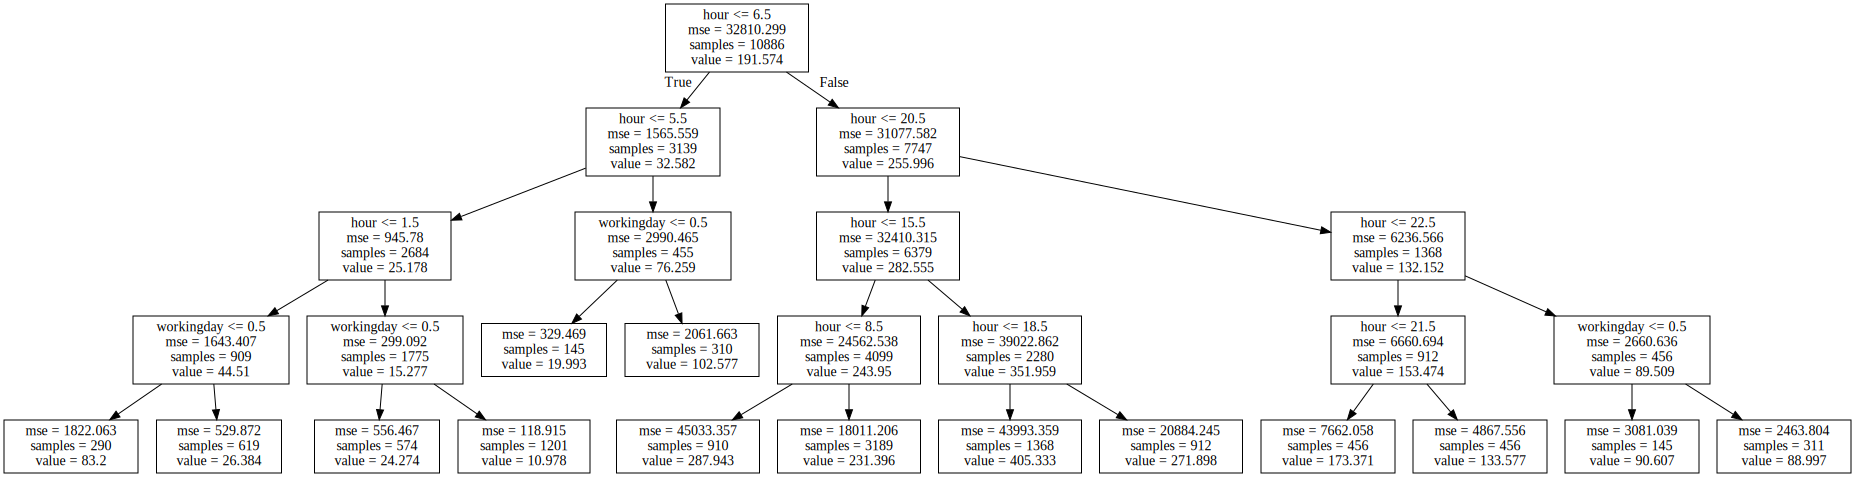

In [18]:
import os
from graphviz import Source
file = open("tree_bikes.dot", "r")
text = file.read()
Source(text)

In [19]:
scores = cross_val_score(treereg, X, y, cv=3)
print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                          scores.std()),
                                          end="\n\n" )

mean: 0.202 (std: 0.253)

